In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [4]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [5]:
# Selecting training_set from begin of 2015 till end of 2017, we can do this because our index in date object
training_data = dataset['2015':'2017'].sort_values('date')

In [147]:
tickers = training_data.ticker.unique()
tickers.sort()
print(tickers)

['A' 'AA' 'AABA' ... 'ZUMZ' 'ZYME' 'ZYNE']


In [24]:
timesteps = 60
x_train = []
y_train = []

for ticker in tickers:
    stock = training_data.loc[training_data['ticker'] == ticker]
    adj_close_data = stock[['adj_close']].values
    for i in range(timesteps, len(adj_close_data)):
        x_train.append(adj_close_data[i-timesteps:i, 0])
        y_train.append(adj_close_data[i, 0])

In [33]:
# Convert into numpy array format
X_train, Y_train = np.array(x_train), np.array(y_train)

In [34]:
# It is kind of data preprocessing in order to obtain more accurancy of our model
# Once I trained our model without transform training set I got higher loss
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)

In [35]:
Y_train = Y_train.reshape(-1,1)
Y_train_scaled = sc.fit_transform(Y_train)

In [37]:
print(X_train_scaled.shape, Y_train_scaled.shape)

(3362879, 60) (3362879, 1)


In [38]:
# Reshaping X_train to match with our GRU network input
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0],X_train_scaled.shape[1],1))

In [39]:
X_train_scaled.shape

(3362879, 60, 1)

In [40]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='loss',patience=3, mode='min')

In [41]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value

regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set

In [43]:
# Training model with earlystopping callbacks function
# It's processing 6000 sample a step
regressorGRU.fit(X_train_scaled,Y_train_scaled,epochs=20,batch_size=6000, callbacks=[es])

Epoch 1/20
3362879/3362879 [==============================] - 301s 89us/step - loss: 2.4466e-05
Epoch 2/20
3362879/3362879 [==============================] - 294s 88us/step - loss: 2.4130e-05
Epoch 3/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.3540e-05
Epoch 4/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.3354e-05
Epoch 5/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.2952e-05
Epoch 6/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.2644e-05
Epoch 7/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.2548e-05
Epoch 8/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.2187e-05
Epoch 9/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.2111e-05
Epoch 10/20
3362879/3362879 [==============================] - 294s 87us/step - loss: 2.1573e-05
Epoch 11/20
3362879/3362879 [==========

# Helper function #

In [385]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))

In [386]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {}'.format(ticker))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predicting on Training data #

In [389]:
stock = training_data.loc[training_data['ticker'] == 'ZUMZ']

In [390]:
stock.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,ZUMZ,38.849998,38.209999,38.209999,37.520000,38.970001,180300
2015-01-05,ZUMZ,38.119999,38.939999,38.939999,37.970001,39.169998,242000
2015-01-06,ZUMZ,38.930000,38.459999,38.459999,38.110001,39.650002,232600
2015-01-07,ZUMZ,38.700001,40.279999,40.279999,38.560001,40.430000,315200
2015-01-08,ZUMZ,40.270000,41.400002,41.400002,39.599998,41.500000,627600


In [391]:
# Define x_train and y_train
x_train = []
y_train = []
adj_close_data = stock[['adj_close']].values
for i in range(timesteps, len(adj_close_data)):
    x_train.append(adj_close_data[i-timesteps:i, 0])
    y_train.append(adj_close_data[i, 0])

In [392]:
X_train, Y_train = np.array(x_train), np.array(y_train)

In [393]:
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0],X_train_scaled.shape[1],1))
Y_train = Y_train.reshape(-1,1)
Y_train_scaled = sc.fit_transform(Y_train)
print(X_train_scaled.shape, Y_train_scaled.shape)

(695, 60, 1) (695, 1)


In [394]:
# Predicting result
predicted_result = regressorGRU.predict(X_train_scaled)
predicted_adj_close = sc.inverse_transform(predicted_result)

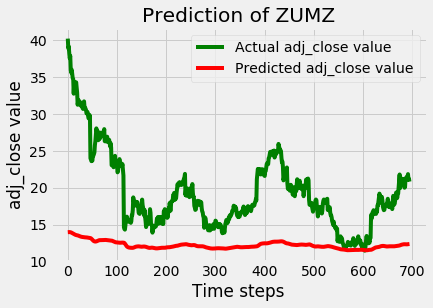

In [395]:
# Plotting graph
plotting_graph(Y_train, predicted_adj_close, 'ZUMZ')

## Calculate MSE on training data ##

In [396]:
# Evaluating our model (applied fit_transform)
return_mse(Y_train_scaled,predicted_result)

The mean squared error is 0.08755257663448938.


In [397]:
# Evaluating our model (without fit_transform)
return_mse(Y_train,predicted_adj_close)

The mean squared error is 72.61961032037863.


# Predicting on Test Data #

In [398]:
# Selecting test set, consider index start from 2018 date object
test_data = dataset['2018':].sort_values('date')

In [399]:
stock = test_data.loc[test_data['ticker'] == 'ZUMZ']

In [400]:
stock.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2018-01-02,ZUMZ,21.450001,20.000000,20.000000,19.900000,21.450001,755600
2018-01-03,ZUMZ,20.000000,20.500000,20.500000,19.600000,20.629999,1364400
2018-01-04,ZUMZ,24.100000,22.950001,22.950001,22.350000,24.450001,1685200
2018-01-05,ZUMZ,23.100000,22.549999,22.549999,22.299999,23.100000,522200
2018-01-08,ZUMZ,22.750000,23.000000,23.000000,22.100000,23.150000,391400


In [401]:
x_test = []
y_test = []
adj_close_data = stock[['adj_close']].values
for i in range(timesteps, len(adj_close_data)):
    x_test.append(adj_close_data[i-timesteps:i, 0])
    y_test.append(adj_close_data[i, 0])

In [402]:
X_test, Y_test = np.array(x_test), np.array(y_test)

In [403]:
sc = MinMaxScaler(feature_range=(0,1))
Y_test = Y_test.reshape(-1,1)
X_test_scaled = sc.fit_transform(X_test)
Y_test_scaled = sc.fit_transform(Y_test)

In [404]:
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [405]:
predicted_result = regressorGRU.predict(X_test_scaled)
predicted_adj_close = sc.inverse_transform(predicted_result)

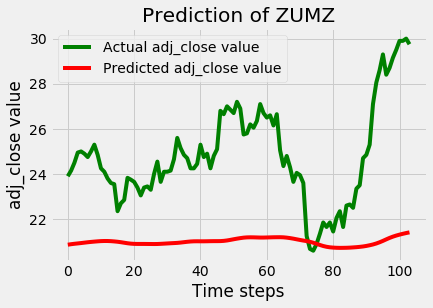

In [406]:
plotting_graph(Y_test, predicted_adj_close, 'ZUMZ')

## Calculate MSE on Test data##

In [407]:
# Evaluating our model (applied fit_transform)
return_mse(Y_test_scaled,predicted_result)

The mean squared error is 0.2122678709272924.


In [408]:
# Evaluating our model (without fit_transform)
return_mse(Y_test,predicted_adj_close)

The mean squared error is 18.755988142850292.
